# Retrieving data from ENCODE
In this short lesson we will learn step by step how to automatically retrieve data from [ENCODE](https://www.encodeproject.org/).

The retrieved data are destined to be used in an experiment on the prediction of CIS-Regulatory regions.

If you haven't installed the library yet, you can do so by running:

```bash
pip install encodeproject
```

First of all let's import some useful packages.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### Retrieving data from ENCODE
ENCODE is a portal offering an immense amount of experimental results. We will be retrieving [epigenomic data](https://en.wikipedia.org/wiki/Epigenomics) created with [ChIP-sequencing](https://en.wikipedia.org/wiki/ChIP-sequencing) (which is a method for measuring the protein-genes interactions) experiments from ENCODE, tabular data containing informations about the expression of genes.

These data are relative to genomic regions characterized as regulatory regions by the labels we will retrieve from FANTOM afterwards.

#### Making a manual query
Let's start by going on [ENCODE](https://www.encodeproject.org/) and see how we can do a manual query.

Afterwards, we will learn how to automate said query.

## Retrieving the experiments
Let's start by running the experiment query, with it's default parameters:

#### Making an automatic query
Automating the data retrieval process is a foundamental aspect for making an experiment fully and easily replicable. Here we will use the package [encodeproject](https://github.com/LucaCappelletti94/encodeproject) to query encode, retrieve the access codes for the experiments we are interested in and download the raw data.

In [2]:
from encodeproject import experiment

experiments = experiment()

That looks easy! Let's now take a look at the available parameters, in depth:

In [3]:
experiments = experiment(
    # The cell line we are interested in.
    # For example values could be K562 or GM12878.
    # We use None to specify that we are not
    # interested in any particular cell line.
    cell_line = None,
    # The reference genomic assembly we want.
    # For example values could be hg19 or GRCh38
    # We use None to specify that we are not
    # interested in any particular genomic assembly.
    assembly = None,
    # The target (the genes coding for proteins in this context) we want.
    # For example values could be CTCF or H3K27ac
    # We use None to specify that we are not
    # interested in any particular target.
    target = None,
    # The status of the data we want.
    # We only want released data, meaning data that are
    # neither old (archived) or with errors (revoked).
    status = 'released',
    # The organism we are considering.
    # Since we only want Homo sapiens data,
    # we specify that organism name.
    organism = 'Homo sapiens',
    # The format of the files we are interested in
    file_type = 'bigWig',
    # We ask to consider only experiments with replicas
    replicated = True,
    # We only want with the signals
    # expressed as "fold change over control"
    searchTerm = "fold change over control",
    # We do not need to specify any other specific
    # additional parameters
    parameters = None,
    # We want to download all the
    # available experiments
    limit = 'all',
    # We want to drop all the experiments
    # which have been characterized by significand issues
    drop_errors = (
        'extremely low read depth',
        'missing control alignments',
        'control extremely low read depth',
        'extremely low spot score',
        'extremely low coverage',
        'extremely low read length',
        'inconsistent control',
        'inconsistent read count'
    )
)

The experiments returned are a lot! Let's start by getting their accession codes!

In [4]:
from encodeproject import accessions

accession_codes = accessions(experiments)

print(f"An accession code look like these: {accession_codes[:3]}")
print(f"We have {len(accession_codes)} accession codes to parse.")

An accession code look like these: ['ENCSR000EFH', 'ENCSR594SMP', 'ENCSR000BPX']
We have 2948 accession codes to parse.


## Querying for the biosamples
Now that we have the accession codes of the experiments that interest us, we can move forward and query them. Since we have a lot of queries to run, we will use the biosamples method, that runs queries in parallel.

As an additional bonus, the queries are cached after they have responded correctly once, so you may see this process run at the speed of light. Without the cached responses, it takes quite a bit longer.

As for the experiments, also the biosamples have some optional filters we can use.

Sa before, let's start from the most basic execution.

In [5]:
from encodeproject import biosamples

samples = biosamples(accession_codes)

Now let's explore the available filters:

In [6]:
hg19 = biosamples(
    # The list of accessions to retrieve
    accessions=accession_codes,
    # Wethever to convert the results in dataframe.
    # The following filters only apply if dataframes are used
    to_dataframe = True,
    # The status of the data we want.
    # We only want released data, meaning data that are
    # neither old (archived) or with errors (revoked).
    status = "released",
    # The organism we want.
    organism = "human",
    # The genomic assembly we want to use
    assembly = "hg19",
    # The output type we want.
    output_type = "fold change over control",
    # And finally the bare minimum amount
    # of biological replicates
    min_biological_replicates = 2
)

Let's look at the first $5$ rows:

In [7]:
hg19[:5]

,status,accession,file_size,file_format,assembly,biological_replicates,output_type,url,organism,cell_line,target
0,released,ENCFF430NXF,848843413,bigWig,hg19,"[1, 2]",fold change over control,https://encode-public.s3.amazonaws.com/2016/08...,human,IMR-90,MAFK
1,released,ENCFF905ZIF,1948498826,bigWig,hg19,"[1, 2]",fold change over control,https://encode-public.s3.amazonaws.com/2017/02...,human,K562,PHF20
2,released,ENCFF511TWR,638644811,bigWig,hg19,"[1, 2]",fold change over control,https://encode-public.s3.amazonaws.com/2017/12...,human,A549,FOXA1
3,released,ENCFF282RLY,2311021838,bigWig,hg19,"[1, 2]",fold change over control,https://encode-public.s3.amazonaws.com/2017/03...,human,22Rv1,H3K27ac
4,released,ENCFF214DHW,910286428,bigWig,hg19,"[1, 2]",fold change over control,https://encode-public.s3.amazonaws.com/2017/12...,human,GM12878,ATF2


Let's see how many unique features we have for each cell line.

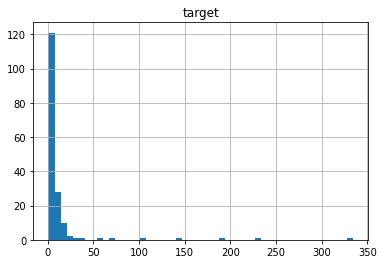

In [8]:
def compute_unique_targets(df:pd.DataFrame):
    return df.groupby(["cell_line"]).agg({"target": "nunique"})

def targets_histogram(df:pd.DataFrame):
    unique_features = compute_unique_targets(df)
    unique_features.hist(bins=50)
    plt.show()

targets_histogram(hg19)

Most cell lines have less than 50 targets, therefore we will need to apply a threshold.

In [9]:
threshold_count = 50
unique_features = compute_unique_targets(hg19)
cell_lines_with_features = unique_features.index[unique_features.target > threshold_count].tolist()
hg19 = hg19[hg19.cell_line.isin(cell_lines_with_features)]

This procedure will have vastly reduced the number of available cell lines. Let's see for each cell line how many unique targets we have left.

In [10]:
compute_unique_targets(hg19)

,target
cell_line,
A549,57
GM12878,144
H1,71
HEK293,192
HepG2,228
K562,334
MCF-7,104


## Downloading the samples
Finally it's time to download the samples! Fortunately we have an utility for this:

In [11]:
from encodeproject import download

urls = hg19.url.tolist()

download(urls[0])

#### On parsing the obtain BigWig files
The [BigWig file format](https://genomebrowser.wustl.edu/goldenPath/help/bigWig.html) is for display of dense, continuous data that will be displayed in the Genome Browser as a graph. BigWig files are created initially from wiggle (wig) type files, using the program wigToBigWig. The resulting bigWig files are in an indexed binary format. The main advantage of the bigWig files is that only the portions of the files needed to display a particular region are transferred to UCSC, so for large data sets bigWig is considerably faster than regular wiggle files.

To parse BigWig files we can use [pybwtool](https://github.com/LucaCappelletti94/pybwtool). 

Before starting to parse the file, which we can think of as a database of genes-protein (single protein, multiple genes) interactions, though we will need the queries to make in the first place! This file is called a [BED file](https://genome.ucsc.edu/FAQ/FAQformat.html#format1).

Since we are interested in studying the cis-regulatory regions, we will retrieve a BED file with coordinates to some of the known regions from [FANTOM](https://fantom.gsc.riken.jp/5/).

#### What is a BED file?
The [BED file format](https://genome.ucsc.edu/FAQ/FAQformat.html#format1) provides a flexible way to define the data lines that are displayed in an annotation track. BED lines have three required fields and nine additional optional fields. The number of fields per line must be consistent throughout any single set of data in an annotation track.